<a href="https://colab.research.google.com/github/CharKuehl/DermalVOCs/blob/main/PTR_Spectra_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro
For the PTR-MS data we first want to analyse and Plot the data and visualise  peakshifts ect.

####Random stuff

In [9]:
from sklearn.base import clone
! git clone https://github.com/CharKuehl/DermalVOCs.git

fatal: destination path 'DermalVOCs' already exists and is not an empty directory.


#Data 

##complete data collection

### Importing & reading data



1.   Intitializing libraries
2.   mounting google drive
3.   making list of folders
4.   making list of files inside folders
5.   reading in all files (cvs read)





In [1]:
import glob
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
sns.set()
from scipy.signal import find_peaks

from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA

import matplotlib
import torch
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# give path to all PTR data folders
PTR_path = 'drive/MyDrive/Colab Notebooks/PTR-MS_data'

In [4]:
# make list of folder names
all_PTR_files_list = os.listdir(PTR_path)
all_PTR_files_list

['all_stripping', 'all_soap', 'all_control', 'all_BHA']

In [5]:
# make list of all files in PTR folders soap, stripping, control and BHA
list_files = []
for files in all_PTR_files_list:
    path = PTR_path + '/' + files
    files_list =  os.listdir(path)
    list_files.append(files_list)
    
list_files        

[['stripping_120min_right_2022.03.18-11h26m23s_AS.csv',
  'stripping_120min_left_2022.03.17-11h23m17s_AS.csv',
  'stripping_120min_left_2022.03.08-12h42m08s_AS.csv',
  'stripping_60min_right_2022.03.18-10h34m44s_AS.csv',
  'stripping_60min_left_2022.03.17-10h39m23s_AS.csv',
  'stripping_60min_left_2022.03.08-11h40m23s_AS.csv',
  'stripping_5min_right_2022.03.18-09h42m53s_AS.csv',
  'stripping_5min_left_2022.03.17-09h56m21s_AS.csv',
  'stripping_5min_left_2022.03.08-10h48m16s_AS.csv'],
 [],
 ['control_120min_right_2022.03.17-11h35m36s_AS.csv',
  'control_120min_right_2022.03.07-15h46m44s_AS.csv',
  'control_60min_right_2022.03.17-10h51m19s_AS.csv',
  'control_60min_right_2022.03.07-14h46m02s_AS.csv',
  'control_5min_right_2022.03.17-10h07m39s_AS.csv',
  'control_5min_right_2022.03.07-13h50m02s_AS.csv',
  'control_0min_stripping_right_2022.03.18-09h17m39s_AS.csv',
  'control_0min_stripping_left_2022.03.17-09h28m22s_AS.csv',
  'control_0min_stripping_left_2022.03.08-10h05m53s_AS.csv',
  '

In [6]:
# make a list ('PTR_df_list') of all PTR dataframes by reading in all csv files inside all folders

label = [l for l in range(0,len(all_PTR_files_list))]
PTR_df_list = []
for i in range(0,len(all_PTR_files_list)):
    folder_names =  all_PTR_files_list[i]
    j = 0
    for file in list_files[i]:

        file = pd.read_csv(PTR_path+'/'+folder_names+'/'+str(file),sep=';')
        file['class'] = label[i]
        file =file.drop(columns = ['Current_Mass','Current'])
        file = file.loc[(file['Average_Mass']> 20) & (file['Average_Mass'] < 300)].reset_index(drop=True)
        j += 1
        PTR_df_list.append(file)

In [ ]:
PTR_df_list

In [79]:
data_PTR = pd.concat(PTR_df_list).reset_index(drop=True)
data_PTR

,Average_Mass,Average,class
0,20.00147,0.28711,0
1,20.00498,0.26427,0
2,20.00848,0.23491,0
3,20.01199,0.24959,0
4,20.01549,0.26591,0
...,...,...,...
1049339,299.94427,2.62804,3
1049340,299.95782,3.06623,3
1049341,299.97141,3.39294,3
1049342,299.98499,3.78366,3


### Peak detection
We detect the peak using scipy peak_finds. \\

**Current problem:** the height of a peak has to be limeted to a certein value. For using teapot later on, we want to keep all the values to feed in as much information as possible.

In [7]:
# peak detection: defining peak threshold for including m_z values

total_df = pd.concat(PTR_df_list).reset_index(drop=True)

# define m/z value as first column of every file
m_z = total_df.iloc[:,0]

# define intensity as second column of every file
intensity= total_df.iloc[:,1]

# creating an average height threshold 5 fast (3 quite slow)

# with scipy.signal.find_peak define minimum height for peak
peaks, indices = find_peaks(intensity, height=3)

m_z = m_z.take(peaks).to_frame() 
m_z = m_z.sort_values(by=['Average_Mass']) #sorting m/z ascending 
m_z = m_z.reset_index(drop=True)

In [8]:
# make a list of the m/z values (deleted verion and rounded version)

m_z_list = m_z['Average_Mass'].values.tolist()
print(m_z_list)
attribute = []
pop_count = 0
duplicate_1 = m_z_list.copy()
duplicate_2 = m_z_list.copy()
for item_1 in m_z_list:

    for item_2 in duplicate_1:
# if difference between two values of m/z is smaller THAN 0.2 OR 0, remove the second item and restart
        if abs(item_1-item_2)<=0.2 and abs(item_1-item_2)!=0:
             if item_2 in duplicate_2:
                duplicate_2.remove(item_2)

    duplicate_1.pop(0)

relevant_mz = np.unique(duplicate_2).tolist()
rounded_mz = np.unique(duplicate_2).astype(int).tolist()

[20.50933, 20.51998, 20.51998, 20.5626, 20.5626, 20.5626, 20.5626, 20.5697, 20.5697, 20.5697, 20.57326, 20.57326, 20.57326, 20.57681, 20.58037, 20.58037, 20.58392, 20.58392, 20.58392, 20.58748, 20.58748, 20.58748, 20.58748, 20.59103, 20.59103, 20.59103, 20.59103, 20.59459, 20.59459, 20.59459, 20.59459, 20.59459, 20.59815, 20.59815, 20.59815, 20.69072, 20.69072, 20.69072, 20.69072, 21.29751, 21.30475, 21.31198, 21.32284, 21.32284, 21.33007, 21.34093, 21.34093, 21.34455, 21.34817, 21.34817, 21.34817, 21.3518, 21.35542, 21.36266, 21.37353, 21.38077, 21.38077, 21.3844, 21.3844, 21.3844, 21.39165, 21.39165, 21.39527, 21.3989, 21.3989, 21.40615, 21.40977, 21.40977, 21.40977, 21.41702, 21.42428, 21.42428, 21.4279, 21.4279, 21.4279, 21.4279, 21.4279, 21.43153, 21.43516, 21.43516, 21.43516, 21.43879, 21.43879, 21.43879, 21.43879, 21.43879, 21.44242, 21.44242, 21.44242, 21.44604, 21.44604, 21.44604, 21.44967, 21.44967, 21.44967, 21.44967, 21.44967, 21.44967, 21.44967, 21.44967, 21.4533, 21.45693

In [9]:
#relevant_mz

In [10]:
#rounded_mz 

In [11]:
PTR_library = pd.read_csv('drive/MyDrive/Colab Notebooks/PTR_Library.csv', sep = ';').dropna()
PTR_library

,Parent Ion Mass,Parent Ion Composition,Compound Name,m/z A
0,18.034,NH3H+,ammonia,18.034
1,27.023,C2H2H+,ethyne,26.015
2,28.018,HCNH+,hydrogen cyanide,28.018
3,28.031,C2H4+,ethene,28.031
4,30.034,CH3NH+,methanimine,30.034
...,...,...,...,...
464,171.211,C12H26H+,n-dodecane,189.221
465,201.185,C12H24O2H+,ethyl decanoate,201.185
466,204.951,C6H5IH+,iodobenzene,204.951
467,218.967,C7H7IH+,2-iodotoluene,218.967


In [ ]:
# read in all compound files 

#PTR = pd.read_csv('drive/MyDrive/Colab Notebooks/PTR_Library.csv').dropna()
compound_names = {}
for value in relevant_mz:
    PT2 = PTR_library.loc[PTR_library['m/z A'].astype(int) == int(value)]
    #print(PT2)
    if PT2.empty:
        empty_list = ['unknown']
        compound_names.update({int(value): empty_list })
    else:
        compounds = PT2['Compound Name'].to_list()
        compound_names.update({int(value): compounds })
        

#print(compound_names)

In [42]:

final_data_list = []

for files in  PTR_df_list:
    mass_per_charge_files = files.iloc[:, 0] #alle m/z Werte in einer Matrix
    ion_intensity_files = files.iloc[:, 1] #alle Intensitätswerte in einer Matrix
    peaks_files, indices_files = find_peaks(ion_intensity_files, height=20) 
    mass_per_charge_files = mass_per_charge_files.take(peaks_files).to_frame() #put m/z of peaks into mpc_files
    #mass_per_charge_files = mass_per_charge_files.sort_values(by=['Average_Mass'])
    #mass_per_charge_files = mass_per_charge_files.reset_index(drop=True)

    mass_per_charge_list_files = mass_per_charge_files['Average_Mass'].values.tolist() #hier werden die tatsächlichen m/z's übertragen

    peak_ion_intensities_files = pd.DataFrame.from_dict(indices_files) #??? what is inside indice files ???

    file = pd.concat([mass_per_charge_files.reset_index(drop=True), peak_ion_intensities_files], axis=1) #-> file = dataframe containing all m/z & peak ion intensities?
    #print(file)
    mz_1 = list(file['Average_Mass'])
    peak_heights = list(file['peak_heights'])
    mz_df_1 = pd.DataFrame(relevant_mz, columns=['Average_Mass'])

    mz_df_1['ion_intensity'] = 0
    
    #i durchsuche die Bibliothek der relevanten m/z Werte
    #j durchsuche alle m/z Werte der files
    #??? j und i sind integers und geben Zeilennummer an, wieso werden die verlichen, ob die differenz <= 0.2 ist? 
    # aktuell werden nur die Werte genommen, bei denen j = i ist (vermutlich heißt das hier alle...)

    for i in relevant_mz:
        for j in mz_1:
            #if i <= j + 0.2:
                if abs(i - j) <= 0.2:

                  #Zeile i in Intensität wird überschrieben mit dem entsprechenden Intensitätswert aus den files an stelle j
                  mz_df_1.loc[mz_df_1.Average_Mass == i, 'ion_intensity'] = file.loc[file['Average_Mass'] == j, 'peak_heights'].item()

    mz_df_1 = list(mz_df_1.iloc[:,1])
    #print(mz_df_1)
    #print(len(mz_df_1))
    mz_df_1 = pd.DataFrame(mz_df_1).transpose()
    mz_df_1.columns = rounded_mz
    #print(mz_df_1)
    mz_df_1['label'] = files.iat[0,2]
    #print(mz_df_1)
    final_data_list.append(mz_df_1) #format not df but list


### PCA

####PCA data prep

In [45]:
data = pd.concat(final_data_list).reset_index(drop=True) # macht aus liste (array) einen df

In [46]:
col = [compound_names[key][0] for key in compound_names] #??? formate
col.append('label')

Creating list 1 and 2 (l1, l2) for VOC identification:

In [61]:
l1 = []
l2 = []
for key in compound_names:
    l1.append(str(key))
    l2.append(compound_names[key][0])
print(l1)
print(l2)

['20', '21', '29', '31', '32', '34', '35', '36', '38', '41', '42', '43', '45', '48', '49', '50', '52', '53', '55', '56', '61', '63', '68', '69', '71', '74', '75', '77', '86', '89', '92', '95', '98', '104', '107', '110', '113', '116', '119', '125', '128', '131', '134', '137', '144', '147', '150', '159', '175', '178', '203', '225', '299']
['unknown', 'unknown', 'unknown', 'formaldehyde', 'unknown', 'hydrogen sulfide', 'unknown', 'unknown', 'unknown', '1,2-propadiene', 'acetonitrile', 'cyclopropane', 'acetaldehyde', 'nitrous acid', 'methane thiol', 'unknown', 'propyne nitrile', '1-buten-3-yne', '2-propynal', 'propane nitrile', 'acetic acid', 'dimethyl sulfide', 'butene nitrile', 'methyl chloride', 'propiolic acid', 'nitroethene', 'ethyl formate', 'thioacetic acid', '2-pyrrolidinone', 'pyruvic acid', 'ethynylpyrrole', 'phenol', '4-methylpentanenitrile', 'benzonitrile', 'benzaldehyde', 'unknown', 'chlorobenzene', 'unknown', 'benzofuran', 'hydroxy benzoquinone', 'unknown', 'dihydronaphthalen

In [ ]:
#res = [i + '_' + j for i, j in zip(l1, l2)]
#res.append('label')
label = l1
l1

In [ ]:
data

In [ ]:
data1 = data.loc[:, data.columns != 'label']

data1 = pd.DataFrame(scaler.fit_transform(data1)) #worauf normieren wir hier? 1???

data1

#### Trying different PCAs

##### 1

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data1)

PCA(n_components=2)

In [ ]:
print(pca.components_)

In [57]:
print(pca.explained_variance_)

[6.3876494  4.87442163]


In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(data1[], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

##### 2

In [67]:
print("original shape (data):   ", data.shape)
print("fitted shape (data1):", data1.shape)

original shape (data):    (32, 55)
fitted shape (data1): (32, 54)


In [73]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(data1)
print(digits.data.shape)
print(projected.shape)

NameError: ignored

####Shravanthis PCS code

In [71]:
data1.columns = res

In [72]:
labels = [x for x in range(0,len(all_PTR_files_list))]
targets = dict(zip(labels,all_PTR_files_list))
targets

{0: 'all_stripping', 1: 'all_soap', 2: 'all_control', 3: 'all_BHA'}

54


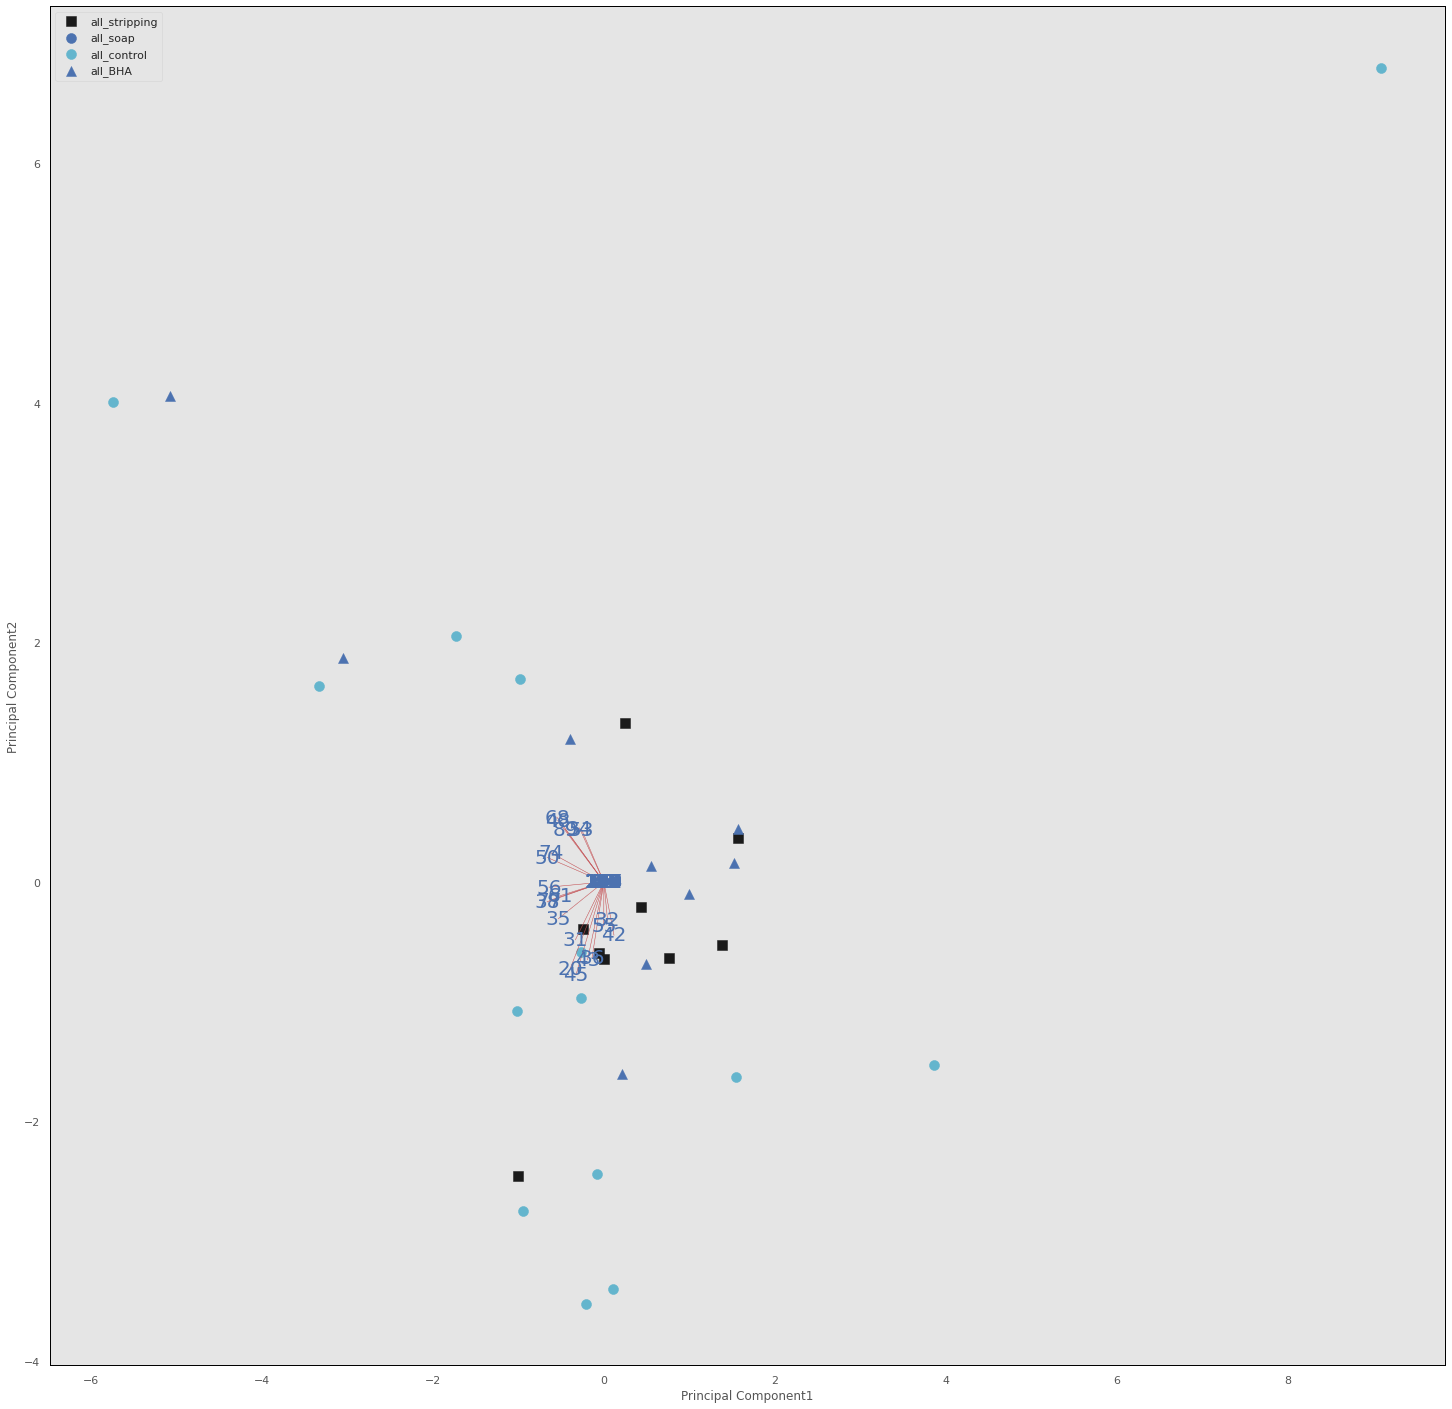

In [34]:
from matplotlib.pyplot import figure
def myplot(score,coeff,targets,finalDf,label=None ):
    finalDf = finalDf
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0] 
    print(n)
    #scalex =2.5/(xs.max() - xs.min())
    #scaley = 2.5/(ys.max() - ys.min())
    #color_list = [{0:"aliceblue",1:"azure",2:"black",3:"brown",4:"cadetblue",5:"coral",6:"crimson",7:"cyan",8:"darkgray",9:"darkgreen",10:"red",11:"gold",12:"ivory",13:"fuchsia",14:"lavender",15:"orange"}[x] for x in data['label']]
    plt.figure(figsize=(10,10))
    targets = targets
    marker = ['s','o','o','^','^','D','D','o','^','D','o','o','^','^','D','D']
    filled = ['k','b','c','b','c','b','c','g','g','g','r','tab:orange','r','tab:orange','r','tab:orange']
    for target, marker, filled in zip(targets,marker,filled):
        indicesToKeep = finalDf['label'] == target

        plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , marker = marker,facecolors = filled,s = 100)
    #set_markerfacecolor(filled)
    plt.legend(targets.values())
    
    
    #plt.scatter(xs  ,ys  ,s=100, c=color_list)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*2, coeff[i,1]*2,color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]*2 , coeff[i,1]*2 , "Var"+str(i+1), size = 20 ,color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]*2 , coeff[i,1]*2  , label[i], size = 20,color = 'b', ha = 'center', va = 'center')
    
    plt.xlabel("Principal Component{}".format(1))
    plt.ylabel("Principal Component{}".format(2))
    plt.grid()
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = "1"  
    plt.savefig('pca_loadingplot.png')

myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2,:]),targets,finalDf,list(data.columns))

## Data collection from GitHub

In [23]:
url_all_BHA_PTR = "https://github.com/CharKuehl/DermalVOCs/tree/main/All-PTR-data/All-BHA-data"

In [24]:
from pathlib import Path

# create a Path instance and filter for only csv files
files = Path("https://github.com/CharKuehl/DermalVOCs/tree/main/All-PTR-data/All-BHA-data").rglob("*.csv")

# read in all the csv files
all_csvs = [pd.read_csv(file) for file in files]

# lump into one table
all_csvs = pd.concat(all_csvs)

all_csvs

ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

####**Tag 1 PTR MS** 
links: BHA \\
rechts: control

In [ ]:
url_0min_left_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-12h48m11s_AS.csv"
url_0min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-13h05m22s_AS.csv"
url_5min_left_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-13h31m08s_AS.csv"
url_5min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-13h50m02s_AS.csv"
url_60min_left_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-14h28m11s_AS.csv"
url_60min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-14h46m02s_AS.csv"
url_120min_left_BHA ="https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-15h26m18s_AS.csv"
url_120min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.07-15h46m44s_AS.csv"

####**Tag 2 PTR MS** 
links: stripping \\
rechts: BHA

In [ ]:
url2_0min_left_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-10h05m53s_AS.csv"
url2_0min_right_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-10h26m22s_AS.csv"
url2_5min_left_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-10h48m16s_AS.csv"
url2_5min_right_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-11h11m09s_AS.csv"
url2_60min_left_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-11h40m23s_AS.csv"
url2_60min_right_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-12h07m15s_AS.csv"
url2_120min_left_stripping ="https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-12h42m08s_AS.csv"
url2_120min_right_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.08-13h07m42s_AS.csv"

####**Tag 3 PTR MS** 
links: stripping \\
rechts: control

In [ ]:
url3_0min_left_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-09h28m22s_AS.csv"
url3_0min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-09h39m47s_AS.csv"
url3_5min_left_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-09h56m21s_AS.csv"
url3_5min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-10h07m39s_AS.csv"
url3_60min_left_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-10h39m23s_AS.csv"
url3_60min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-10h51m19s_AS.csv"
url3_120min_left_stripping ="https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-11h23m17s_AS.csv"
url3_120min_right_control = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.17-11h35m36s_AS.csv"

####**Tag 4 PTR MS** 
links: BHA \\
rechts: stripping

In [ ]:
url4_0min_left_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-09h06m35s_AS.csv"
url4_0min_right_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-09h17m39s_AS.csv"
url4_5min_left_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-09h29m19s_AS.csv"
url4_5min_right_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-09h42m53s_AS.csv"
url4_60min_left_BHA = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-10h16m18s_AS.csv"
url4_60min_right_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-10h34m44s_AS.csv"
url4_120min_left_BHA ="https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-11h13m02s_AS.csv"
url4_120min_right_stripping = "https://raw.githubusercontent.com/CharKuehl/DermalVOCs/main/DataFile_2022.03.18-11h26m23s_AS.csv"

###Read in BHA data

####07.03.2022

 **07.03. 0 min BHA:**

In [ ]:
df = pd.read_csv(url_0min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_0min_left_BHA = df[df['m/z'] > 19]  
df0307_0min_left_BHA = df[df['m/z'] < 200]
#df0307_0min_left_BHA = df[df.m/z <= 20]
#df0307_0min_left_BHA = df.drop(df[df['m/z'] <= 20].index, inplace = True)
#df0307_0min_left_BHA

**07.03. 5 min BHA:**

In [ ]:
df = pd.read_csv(url_5min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_5min_left_BHA = df[df['m/z'] > 19]  
df0307_5min_left_BHA = df[df['m/z'] < 200]
#df_0min_left_BHA = df[df.m/z <= 20]
#df_0min_left_BHA = df.drop(df[df['m/z'] <= 20].index, inplace = True)
#df0307_5min_left_BHA

**07.03. 60 min BHA:**

In [ ]:
df = pd.read_csv(url_60min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_60min_left_BHA = df[df['m/z'] > 19]  
df0307_60min_left_BHA = df[df['m/z'] < 200]
#df_0min_left_BHA = df[df.m/z <= 20]
#df_0min_left_BHA = df.drop(df[df['m/z'] <= 20].index, inplace = True)
#df0307_60min_left_BHA

**07.03. 120 min BHA:**

In [ ]:
df = pd.read_csv(url_120min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_120min_left_BHA = df[df['m/z'] > 19]  
df0307_120min_left_BHA = df[df['m/z'] < 200]
#df_0min_left_BHA = df[df.m/z <= 20]
#df_0min_left_BHA = df.drop(df[df['m/z'] <= 20].index, inplace = True)
#df0307_120min_left_BHA

####08.03.2022


**08.03. right 0 min BHA:**

In [ ]:
df = pd.read_csv(url2_0min_right_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_0min_right_BHA = df[df['m/z'] > 19]  
df0308_0min_right_BHA = df[df['m/z'] < 200]
df0308_0min_right_BHA

**08.03. right 5 min BHA:**

In [ ]:
df = pd.read_csv(url2_5min_right_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_5min_right_BHA = df[df['m/z'] > 19]  
df0308_5min_right_BHA = df[df['m/z'] < 200]
df0308_5min_right_BHA

**08.03. right 60 min BHA:**

In [ ]:
df = pd.read_csv(url2_60min_right_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_60min_right_BHA = df[df['m/z'] > 19]  
df0308_60min_right_BHA = df[df['m/z'] < 200]
df0308_60min_right_BHA

**08.03. right 120 min BHA:**

In [ ]:
df = pd.read_csv(url2_120min_right_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_120min_right_BHA = df[df['m/z'] > 19]  
df0308_120min_right_BHA = df[df['m/z'] < 200]
df0308_120min_right_BHA

####18.03.2022


**18.03. left 0 min BHA:**

In [ ]:
df = pd.read_csv(url4_0min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_0min_right_BHA = df[df['m/z'] > 19]  
df0318_0min_right_BHA = df[df['m/z'] < 200]
df0318_0min_right_BHA

**18.03. left 5 min BHA:**

In [ ]:
df = pd.read_csv(url4_5min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_5min_right_BHA = df[df['m/z'] > 19]  
df0318_5min_right_BHA = df[df['m/z'] < 200]
df0318_5min_right_BHA

**18.03. left 60 min BHA:**

In [ ]:
df = pd.read_csv(url4_60min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_60min_right_BHA = df[df['m/z'] > 19]  
df0318_60min_right_BHA = df[df['m/z'] < 200]
df0318_60min_right_BHA

**18.03. left 120 min BHA:**

In [ ]:
df = pd.read_csv(url4_120min_left_BHA, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_120min_right_BHA = df[df['m/z'] > 19]  
df0318_120min_right_BHA = df[df['m/z'] < 200]
df0318_120min_right_BHA

###Read in Stripping data

####08.03.2022

**08.03. left 0 min:**

In [ ]:
df = pd.read_csv(url2_0min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_0min_left_stripping = df[df['m/z'] > 19]  
df0308_0min_left_stripping = df[df['m/z'] < 200]
#df0308_0min_left_stripping

**08.03. left 5 min:**

In [ ]:
df = pd.read_csv(url2_5min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_5min_left_stripping = df[df['m/z'] > 19]  
df0308_5min_left_stripping = df[df['m/z'] < 200]
df0308_5min_left_stripping

**08.03. left 60 min:**

In [ ]:
df = pd.read_csv(url2_60min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_60min_left_stripping = df[df['m/z'] > 19]  
df0308_60min_left_stripping = df[df['m/z'] < 200]
#df0308_60min_left_stripping

**08.03. left 120 min:**

In [ ]:
df = pd.read_csv(url2_120min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0308_120min_left_stripping = df[df['m/z'] > 19]  
df0308_120min_left_stripping = df[df['m/z'] < 200]
#df0308_120min_left_stripping

####17.03.2022

**17.03. left 0 min:**

In [ ]:
df = pd.read_csv(url3_0min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_0min_left_stripping = df[df['m/z'] > 19]  
df0317_0min_left_stripping = df[df['m/z'] < 200]
#df0317_0min_left_stripping

**17.03. left 5 min:**

In [ ]:
df = pd.read_csv(url3_5min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_5min_left_stripping = df[df['m/z'] > 19]  
df0317_5min_left_stripping = df[df['m/z'] < 200]
#df0317_5min_left_stripping

**17.03. left 60 min:**

In [ ]:
df = pd.read_csv(url3_60min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_60min_left_stripping = df[df['m/z'] > 19]  
df0317_60min_left_stripping = df[df['m/z'] < 200]
#df0317_60min_left_stripping

**17.03. left 120 min:**

In [ ]:
df = pd.read_csv(url3_120min_left_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_120min_left_stripping = df[df['m/z'] > 19]  
df0317_120min_left_stripping = df[df['m/z'] < 200]
#df0317_120min_left_stripping

####18.03.2022

**18.03. right stripping 0 min:**

In [ ]:
df = pd.read_csv(url4_0min_right_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_0min_right_stripping = df[df['m/z'] > 19]  
df0318_0min_right_stripping = df[df['m/z'] < 200]
df0318_0min_right_stripping

**18.03. right stripping 5 min:**

In [ ]:
df = pd.read_csv(url4_5min_right_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_5min_right_stripping = df[df['m/z'] > 19]  
df0318_5min_right_stripping = df[df['m/z'] < 200]
df0318_5min_right_stripping

**18.03. right stripping 60 min:**

In [ ]:
df = pd.read_csv(url4_60min_right_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_60min_right_stripping = df[df['m/z'] > 19]  
df0318_60min_right_stripping = df[df['m/z'] < 200]
df0318_60min_right_stripping

**18.03. right stripping 120 min:**

In [ ]:
df = pd.read_csv(url4_120min_right_stripping, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0318_120min_right_stripping = df[df['m/z'] > 19]  
df0318_120min_right_stripping = df[df['m/z'] < 200]
df0318_120min_right_stripping

### Read in control data

####07.03.2022

**07.03. 0 min control:**

In [ ]:
df = pd.read_csv(url_0min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_0min_right_control = df[df['m/z'] > 19]  
df0307_0min_right_control = df[df['m/z'] < 200]
#df0307_0min_right_control

**07.03. 5 min control:**

In [ ]:
df = pd.read_csv(url_5min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_5min_right_control = df[df['m/z'] > 19]  
df0307_5min_right_control = df[df['m/z'] < 200]
#df0307_5min_right_control

**07.03. 60 min control:**

In [ ]:
df = pd.read_csv(url_60min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_60min_right_control = df[df['m/z'] > 19]  
df0307_60min_right_control = df[df['m/z'] < 200]
#df0307_60min_right_control

**07.03. 120 min control:**

In [ ]:
df = pd.read_csv(url_120min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0307_120min_right_control = df[df['m/z'] > 19]  
df0307_120min_right_control = df[df['m/z'] < 200]
#df0307_120min_right_control

####17.03.2022

**17.03. 0 min control:**

In [ ]:
df = pd.read_csv(url3_0min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_0min_right_control = df[df['m/z'] > 19]  
df0317_0min_right_control = df[df['m/z'] < 200]
df0317_0min_right_control

**17.03. 5 min control:**

In [ ]:
df = pd.read_csv(url3_5min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_5min_right_control = df[df['m/z'] > 19]  
df0317_5min_right_control = df[df['m/z'] < 200]
df0317_5min_right_control

**17.03. 60 min control:**

In [ ]:
df = pd.read_csv(url3_60min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_60min_right_control = df[df['m/z'] > 19]  
df0317_60min_right_control = df[df['m/z'] < 200]
#df0317_60min_right_control

**17.03. 120 min control:**

In [ ]:
df = pd.read_csv(url3_120min_right_control, sep= ";")
df = df.iloc[:,0:]
df = df.drop(columns=["Current_Mass", "Current"])
df = df.rename(columns={"Average_Mass": "m/z", "Average": "intensity"})
df0317_120min_right_control = df[df['m/z'] > 19]  
df0317_120min_right_control = df[df['m/z'] < 200]
#df0317_120min_right_control

#Plotting libraries 1st try 
Here some information about building interactive plots in Python can be found: [Interactive Python Plot Libraries](https://mode.com/blog/python-interactive-plot-libraries/)

###Bokeh

In [43]:
pip install bokeh

In [ ]:
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show

output_notebook()


#change theme for visibility
curdoc().theme = 'dark_minimal' #caliber, light_minimal, dark_minimal, night_sky, contrast

# prepare data
x = df0307_0min_left_BHA['m/z']
y = df0307_0min_left_BHA['intensity']

# create a new plot with a title and axis labels
p = figure (title='VOC sample plot comparision 0-120 min', x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)) #, x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)
# add a line renderer with legend and line thickness
p.line(x, y, legend_label="VOCs", line_width=2)

# show the results
#output_file("voc.html")

show(p)

In [ ]:
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show

output_notebook()


#change theme for visibility
curdoc().theme = 'dark_minimal' #caliber, light_minimal, dark_minimal, night_sky, contrast

# prepare data
x0 = df0307_0min_left_BHA['m/z']
y0 = df0307_0min_left_BHA['intensity']
x1 = df0307_5min_left_BHA['m/z']
y1 = df0307_5min_left_BHA['intensity']
x2 = df0307_60min_left_BHA['m/z']
y2 = df0307_60min_left_BHA['intensity']
x3 = df0307_120min_left_BHA['m/z']
y3 = df0307_120min_left_BHA['intensity']

# create a new plot with a title and axis labels
p = figure (title='VOC sample plot comparision 0-120 min', x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)) #, x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)
# add a line renderer with legend and line thickness
#p.line(x, y, legend_label="VOCs", line_width=2)

# add multiple renderers
#p.line(x0, y0, legend_label="0 min", color="blue", line_width=2)
p.line(x1, y1, legend_label="5 min", color="red", line_width=2)
p.line(x2, y2, legend_label="60 min", color="green", line_width=2)
p.line(x3, y3, legend_label="120 min", color="yellow", line_width=2)

# show the results
#output_file("voc.html")

show(p)

In [ ]:
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show

output_notebook()


#change theme for visibility
curdoc().theme = 'dark_minimal' #caliber, light_minimal, dark_minimal, night_sky, contrast

# prepare data
x0 = df0307_0min_right_control['m/z']
y0 = df0307_0min_right_control['intensity']
x1 = df0307_5min_right_control['m/z']
y1 = df0307_5min_right_control['intensity']
x2 = df0307_60min_right_control['m/z']
y2 = df0307_60min_right_control['intensity']
x3 = df0307_120min_right_control['m/z']
y3 = df0307_120min_right_control['intensity']

# create a new plot with a title and axis labels
p = figure (title='VOC sample plot comparision 0-120 min control', x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)) #, x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)
# add a line renderer with legend and line thickness
#p.line(x, y, legend_label="VOCs", line_width=2)

# add multiple renderers
p.line(x0, y0, legend_label="0 min", color="blue", line_width=2)
p.line(x1, y1, legend_label="5 min", color="red", line_width=2)
p.line(x2, y2, legend_label="60 min", color="green", line_width=2)
p.line(x3, y3, legend_label="120 min", color="yellow", line_width=2)

# show the results
#output_file("voc.html")

show(p)

Plot of 0min left arm BHA day 1

#Spectra comparision and analysis PTR

## Changes in spectra over time ompared to control 
In this part I want to subtract the changes between the inital treatment, 60 minutes and 120 minutes later and plot these subtractions compared to those of the control samples. 

### Variance within the control samples
So far I have gathered two control measurements on the 7th and 17th of March. I want to subtract the spectra from one another to visualize the variance to better understand the data. Idealy We would wish for completely straight lines to assure that the variance within the measuring period of controls is negligible. 

In [ ]:
#df0307_0min_right_control
#df0307_5min_right_control
#df0307_60min_right_control
#df0307_120min_right_control
df0307_control_subtract0_5 = df0307_0min_right_control.subtract(df0307_5min_right_control, axis = 1)
df0307_control_subtract0_60 = df0307_0min_right_control.subtract(df0307_60min_right_control, axis = 1)
df0307_control_subtract5_60 = df0307_5min_right_control.subtract(df0307_60min_right_control, axis = 1)

In [ ]:
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show

output_notebook()


#change theme for visibility
curdoc().theme = 'dark_minimal' #caliber, light_minimal, dark_minimal, night_sky, contrast

# prepare data
x = df0307_control_subtract5_60['m/z']
y = df0307_control_subtract5_60['intensity']

# create a new plot with a title and axis labels
p = figure (title='VOC subtraction plot control 0-60min', x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)) #, x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)
# add a line renderer with legend and line thickness
p.line(x, y, legend_label="VOCs", line_width=2)

# show the results
#output_file("voc.html")

show(p)

### Variance within the BHA samples

In [ ]:
#df0307_0min_left_BHA
#df0307_5min_left_BHA
#df0307_60min_left_BHA
#df0307_120min_left_BHA
df0307_BHA_subtract0_5 = df0307_0min_left_BHA.subtract(df0307_5min_left_BHA, axis = 1)
#df0307_control_subtract0_60 = df0307_0min_right_control.subtract(df0307_60min_right_control, axis = 1)
#df0307_control_subtract5_60 = df0307_5min_right_control.subtract(df0307_60min_right_control, axis = 1)
df0307_BHA_subtract0_5

In [ ]:
df0307_BHA_subtract0_5 = df0307_0min_left_BHA.subtract(df0307_5min_left_BHA, axis = 1)

from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show

output_notebook()


#change theme for visibility
curdoc().theme = 'dark_minimal' #caliber, light_minimal, dark_minimal, night_sky, contrast

# prepare data
x = df0307_BHA_subtract0_5['m/z']
y = df0307_BHA_subtract0_5['intensity']

# create a new plot with a title and axis labels
p = figure (title='VOC subtraction plot control 0-60min', x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)) #, x_axis_label='m/z', y_axis_label='intensity [ppb]',width=900, height=400, x_range=(30, 70), y_range=(0, 4000)
# add a line renderer with legend and line thickness
p.line(x, y, legend_label="VOCs", line_width=2)

# show the results
#output_file("voc.html")

show(p)